In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
import pyarrow

Referenced from: https://github.com/jpsam07/skyline-hospital-time-series-forecasting-with-xgboost?tab=readme-ov-file#data-collection

In [2]:
filepath = 'sample-data/mini_traffic.csv' # change as needed

df = pd.read_csv(filepath)

df.head()


,date,0,1,2,3,4,5,6,7,8,9
0,2016-07-01 02:00:00,0.0048,0.0146,0.0289,0.0142,0.0064,0.0232,0.0162,0.0242,0.0341,0.0375
1,2016-07-01 03:00:00,0.0072,0.0148,0.0350,0.0174,0.0084,0.0240,0.0201,0.0338,0.0434,0.0381
2,2016-07-01 04:00:00,0.0040,0.0101,0.0267,0.0124,0.0049,0.0170,0.0127,0.0255,0.0332,0.0309
3,2016-07-01 05:00:00,0.0039,0.0060,0.0218,0.0090,0.0029,0.0118,0.0088,0.0163,0.0211,0.0199
4,2016-07-01 06:00:00,0.0042,0.0055,0.0191,0.0082,0.0024,0.0095,0.0064,0.0087,0.0144,0.0226


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3000 non-null   object 
 1   0       3000 non-null   float64
 2   1       3000 non-null   float64
 3   2       3000 non-null   float64
 4   3       3000 non-null   float64
 5   4       3000 non-null   float64
 6   5       3000 non-null   float64
 7   6       3000 non-null   float64
 8   7       3000 non-null   float64
 9   8       3000 non-null   float64
 10  9       3000 non-null   float64
dtypes: float64(10), object(1)
memory usage: 257.9+ KB


In [4]:
df = df.set_index('date')
df

,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
2016-07-01 02:00:00,0.0048,0.0146,0.0289,0.0142,0.0064,0.0232,0.0162,0.0242,0.0341,0.0375
2016-07-01 03:00:00,0.0072,0.0148,0.0350,0.0174,0.0084,0.0240,0.0201,0.0338,0.0434,0.0381
2016-07-01 04:00:00,0.0040,0.0101,0.0267,0.0124,0.0049,0.0170,0.0127,0.0255,0.0332,0.0309
2016-07-01 05:00:00,0.0039,0.0060,0.0218,0.0090,0.0029,0.0118,0.0088,0.0163,0.0211,0.0199
2016-07-01 06:00:00,0.0042,0.0055,0.0191,0.0082,0.0024,0.0095,0.0064,0.0087,0.0144,0.0226
...,...,...,...,...,...,...,...,...,...,...
2016-11-02 21:00:00,0.0246,0.0250,0.0485,0.0628,0.0090,0.0512,0.0405,0.0632,0.0628,0.0388
2016-11-02 22:00:00,0.0160,0.0220,0.0451,0.0546,0.0028,0.0403,0.0320,0.0557,0.0602,0.0243
2016-11-02 23:00:00,0.0063,0.0173,0.0376,0.0405,0.0000,0.0310,0.0240,0.0522,0.0562,0.0205


In [5]:
# Calculate the average across sensor columns
df['sensor'] = df.iloc[:, 1:].mean(axis=1)

# Drop the individual sensor columns
df.drop(columns=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], inplace=True)

# Display the updated DataFrame
# df.rename(columns={'100': 'sensor'}, inplace=True)
print(df.head())


                       sensor
date                         
2016-07-01 02:00:00  0.022144
2016-07-01 03:00:00  0.026111
2016-07-01 04:00:00  0.019267
2016-07-01 05:00:00  0.013067
2016-07-01 06:00:00  0.010756


In [6]:
df = df.copy()
df['date'] = pd.to_datetime(df.index)
df['day_of_week'] = df['date'].dt.dayofweek
df.head()

,sensor,date,day_of_week
date,,,
2016-07-01 02:00:00,0.022144,2016-07-01 02:00:00,4
2016-07-01 03:00:00,0.026111,2016-07-01 03:00:00,4
2016-07-01 04:00:00,0.019267,2016-07-01 04:00:00,4
2016-07-01 05:00:00,0.013067,2016-07-01 05:00:00,4
2016-07-01 06:00:00,0.010756,2016-07-01 06:00:00,4


<Axes: xlabel='day_of_week'>

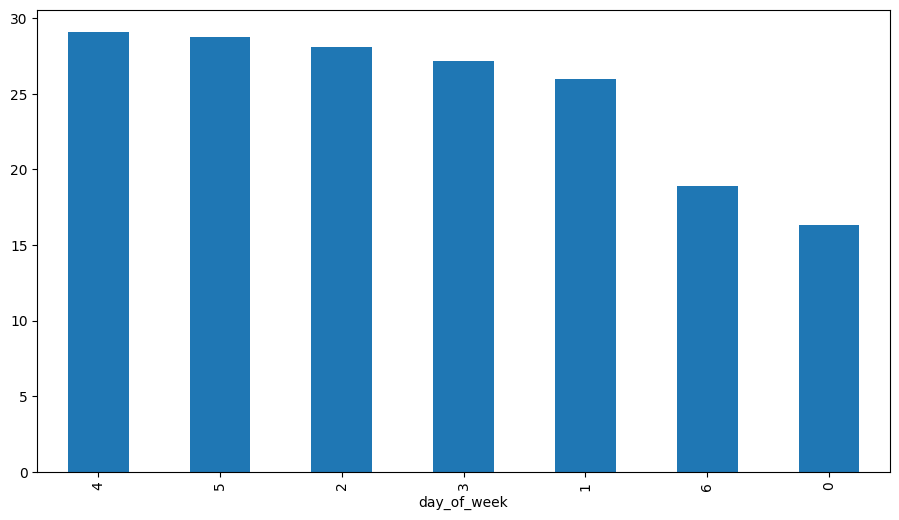

In [7]:
df.groupby('day_of_week')['sensor'].sum().sort_values(ascending=False) \
    .plot(kind='bar', figsize=(11, 6))


In [8]:
from statsmodels.tsa.seasonal import STL

In [9]:
import pandas as pd
from statsmodels.tsa.seasonal import STL

# Assuming 'sensor' is the column containing the traffic data
traffic_series = df['sensor']

# Step 1: Ensure the index is a datetime index
df.index = pd.to_datetime(df.index)

# Step 2: Extract 'sensor' as a pandas Series
traffic_series = df['sensor']

# Step 3: Convert the data type of the Series to numeric (if needed)
traffic_series = pd.to_numeric(traffic_series, errors='coerce')

# Perform STL decomposition
stl = STL(traffic_series, seasonal= 7)  # Assuming hourly data with weekly seasonality
result = stl.fit()

print(stl, result, sep='\n')


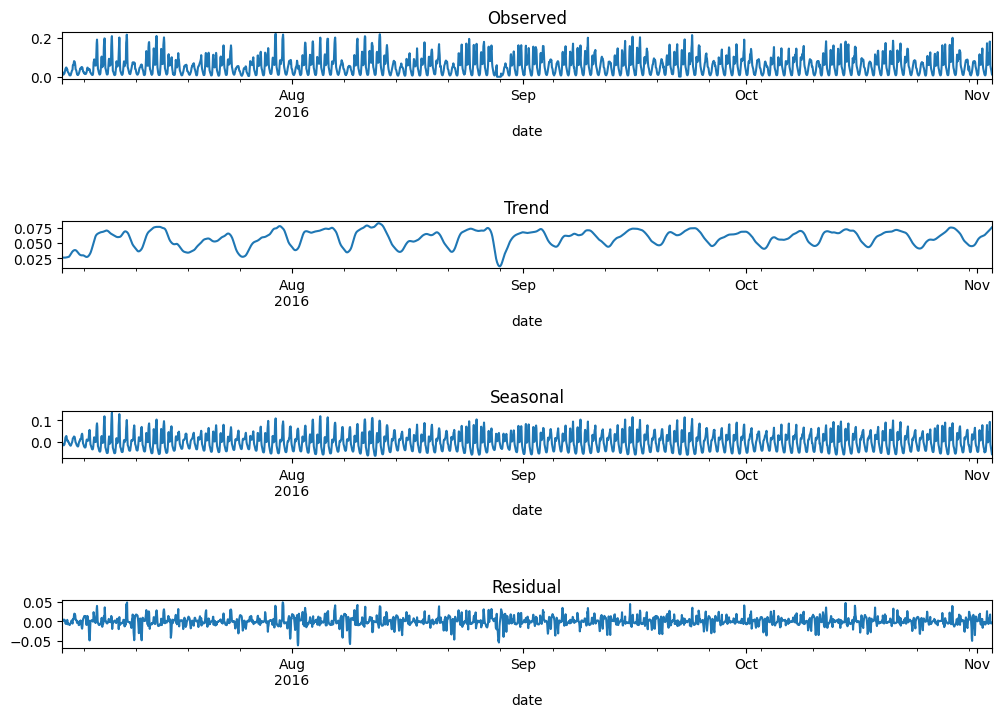

In [10]:
# Plot the components
fig, ax = plt.subplots(4, 1, figsize=(12, 8))
plt.subplots_adjust(hspace=3)

# Observed component
result.observed.plot(ax=ax[0], legend=False)
ax[0].set_title('Observed')

# Trend component
result.trend.plot(ax=ax[1], legend=False)
ax[1].set_title('Trend')

# Seasonal component
result.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_title('Seasonal')

# Residual component
result.resid.plot(ax=ax[3], legend=False)
ax[3].set_title('Residual')

# Show plot
plt.show()

In [11]:
# Calculate the 25th and 75th quantiles and the IQR
Q1 = traffic_series.quantile(0.25)
Q3 = traffic_series.quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds
lower_bound = Q1 - 0.1 * IQR
upper_bound = Q3 + 0.9 * IQR

print(f'Lower Bound: {lower_bound}')
print(f'Upper Bound: {upper_bound}')

Lower Bound: 0.013186944444444442
Upper Bound: 0.13383694444444444


In [12]:
def custom_winsorize(x):
    if x < lower_bound:
        return lower_bound
    elif x > upper_bound:
        return upper_bound
    else:
        return x

cleaned_series = traffic_series.copy()
cleaned_series = cleaned_series.apply(custom_winsorize)
df['Traffic'] = cleaned_series.copy()

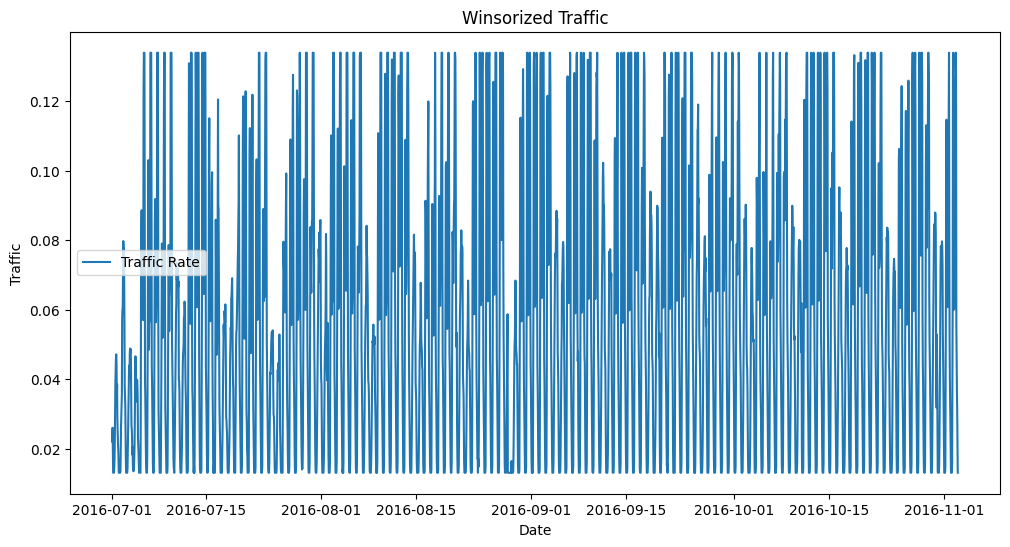

In [13]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the winsorized time series data
ax.plot(df.index, 'Traffic', data=df,
       label='Traffic Rate')

# Plot title and labels
ax.set_title('Winsorized Traffic')
ax.set_xlabel('Date')
ax.set_ylabel('Traffic')

# Show legend
plt.legend()

# Show plot
plt.show()

In [14]:
def create_features(df, label=None):
    """
    Create time series features from the datetime index
    """
    df = df.copy()
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear
    
    window_size = 7  # 7-day rolling window
    
    # Rolling minimum
    df['rolling_min'] = df['Traffic'].rolling(window=window_size).min()
    
    # Rolling maximum
    df['rolling_max'] = df['Traffic'].rolling(window=window_size).max()
    
    # Rolling sum
    df['rolling_sum'] = df['Traffic'].rolling(window=window_size).sum()
    
    # Rollling mean
    df['rolling_mean'] = df['Traffic'].rolling(window=window_size).mean()
    
    # Rolling median
    df['rolling_median'] = df['Traffic'].rolling(window=window_size).median()
    
    # Rolling standard deviation
    df['rolling_std'] = df['Traffic'].rolling(window=window_size).std()
    
    # Rolling 25th percentile
    df['rolling_quantile_25'] = df['Traffic'].rolling(window=window_size).quantile(0.25)
    
    # Rolling 75th percentile
    df['rolling_quantile_75'] = df['Traffic'].rolling(window=window_size).quantile(0.75)
    return df

df = create_features(df)
df.dtypes

sensor                        float64
date                   datetime64[ns]
day_of_week                     int32
Traffic                       float64
month                           int32
day_of_year                     int32
rolling_min                   float64
rolling_max                   float64
rolling_sum                   float64
rolling_mean                  float64
rolling_median                float64
rolling_std                   float64
rolling_quantile_25           float64
rolling_quantile_75           float64
dtype: object

In [15]:
from sklearn.model_selection import TimeSeriesSplit

In [16]:
rows = len(df)
n_splits = 5 # change as needed
test_size = int(np.floor(rows/n_splits)) - 1
print(rows, test_size)
tss = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=1)
df = df.sort_index()

3000 599


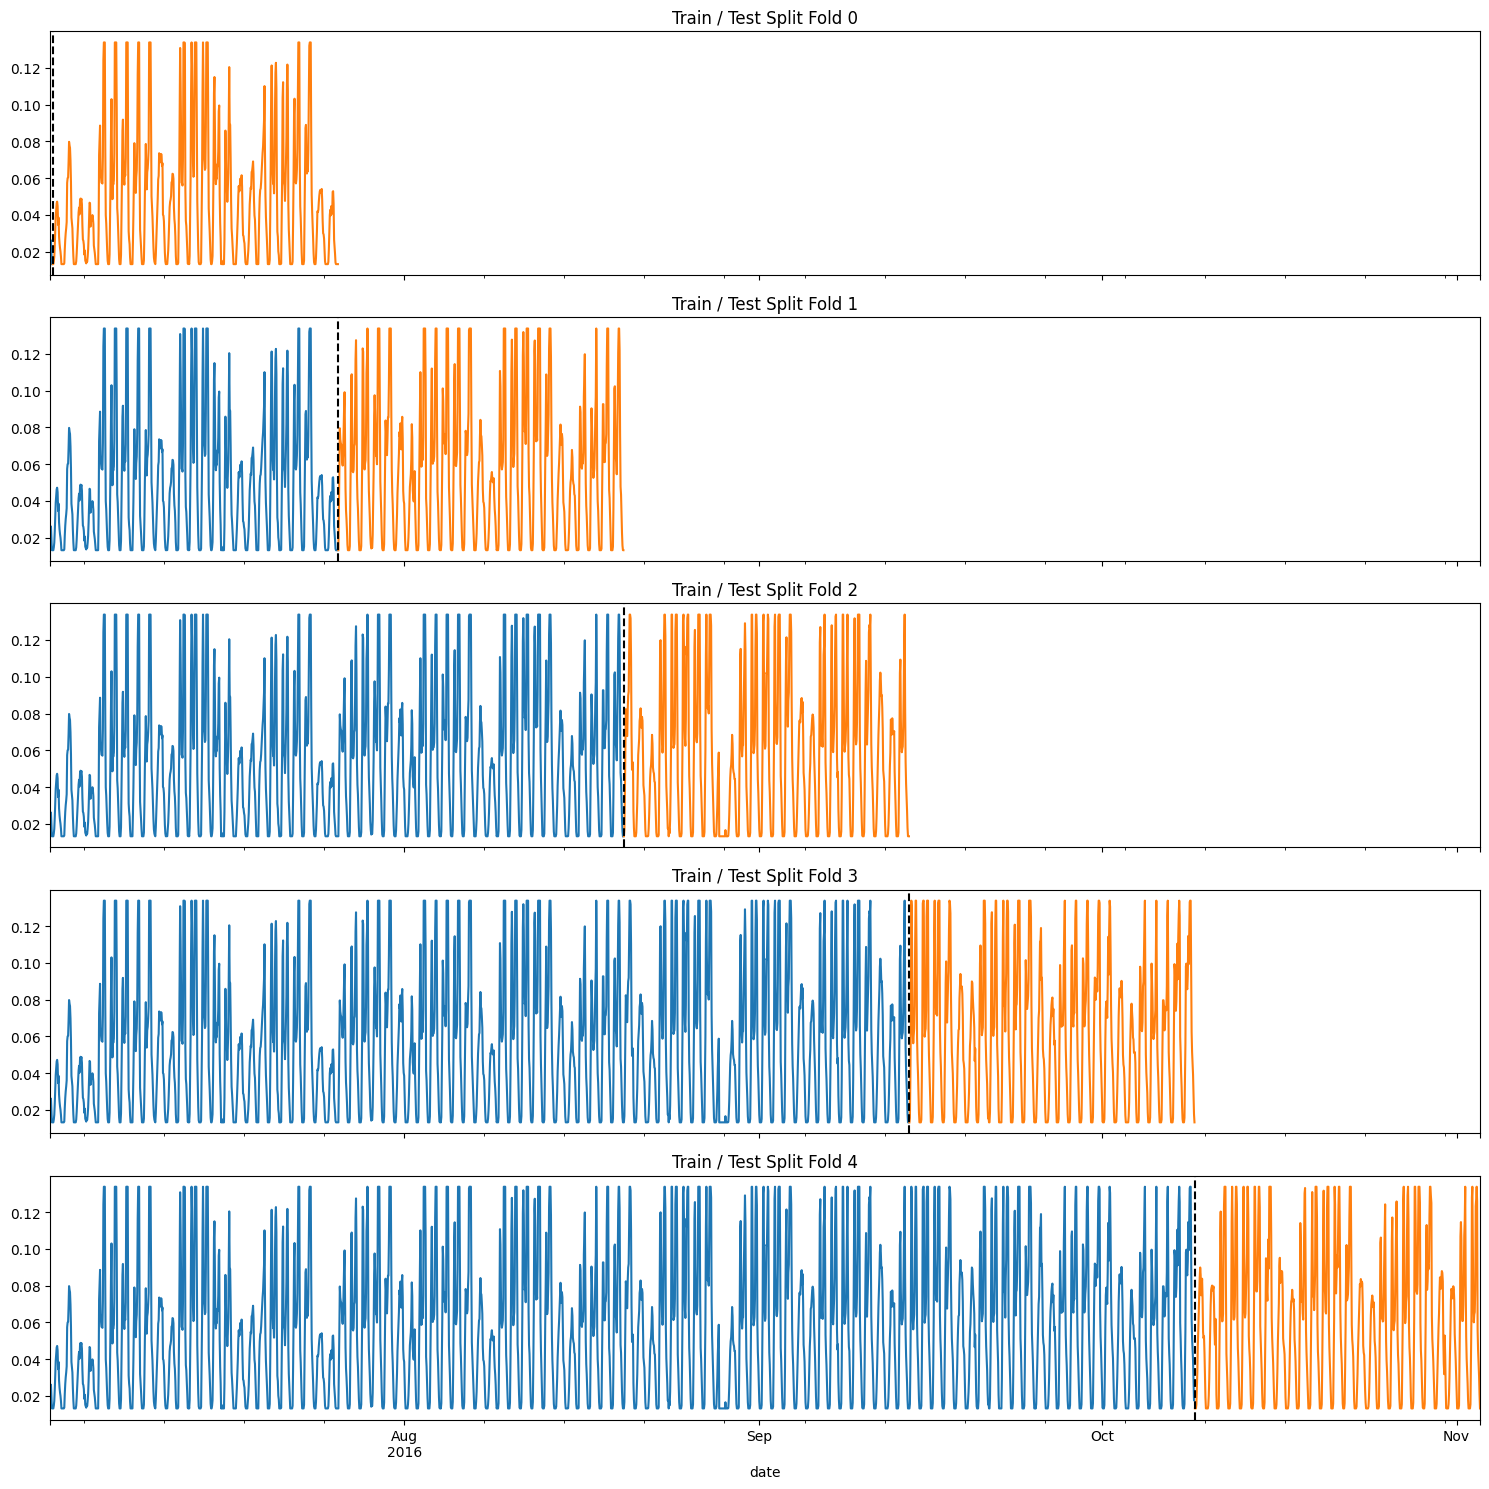

In [17]:
fig, axs = plt.subplots(n_splits, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]
    train['Traffic'].plot(ax=axs[fold],
                           label='Training Set',
                           title=f'Train / Test Split Fold {fold}')
    test['Traffic'].plot(ax=axs[fold], label='Test Set')
    
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

plt.tight_layout()
plt.show()

In [18]:
df

,sensor,date,day_of_week,Traffic,month,day_of_year,rolling_min,rolling_max,rolling_sum,rolling_mean,rolling_median,rolling_std,rolling_quantile_25,rolling_quantile_75
date,,,,,,,,,,,,,,
2016-07-01 02:00:00,0.022144,2016-07-01 02:00:00,4,0.022144,7,183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 03:00:00,0.026111,2016-07-01 03:00:00,4,0.026111,7,183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 04:00:00,0.019267,2016-07-01 04:00:00,4,0.019267,7,183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 05:00:00,0.013067,2016-07-01 05:00:00,4,0.013187,7,183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 06:00:00,0.010756,2016-07-01 06:00:00,4,0.013187,7,183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-02 21:00:00,0.044644,2016-11-02 21:00:00,2,0.044644,11,307,0.044644,0.133837,0.688004,0.098286,0.123344,0.037873,0.066628,0.126461
2016-11-02 22:00:00,0.037444,2016-11-02 22:00:00,2,0.037444,11,307,0.037444,0.133837,0.647770,0.092539,0.123344,0.044068,0.050111,0.126461
2016-11-02 23:00:00,0.031033,2016-11-02 23:00:00,2,0.031033,11,307,0.031033,0.133837,0.555459,0.079351,0.055578,0.047026,0.041044,0.126461


In [19]:
def add_lags(df):
    """
    Create time lags for added time series features and allow the model to learn the temporal structure of the data.
    """
    target_map = df['Traffic'].to_dict()
    df['lag_7_days'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag_14_days'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag_21_days'] = (df.index - pd.Timedelta('21 days')).map(target_map)
    df['lag_28_days'] = (df.index - pd.Timedelta('28 days')).map(target_map)
    df['lag_30_days'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag_35_days'] = (df.index - pd.Timedelta('35 days')).map(target_map)
    df['lag_42_days'] = (df.index - pd.Timedelta('42 days')).map(target_map)
    df['lag_49_days'] = (df.index - pd.Timedelta('49 days')).map(target_map)
    df['lag_56_days'] = (df.index - pd.Timedelta('56 days')).map(target_map)
    df['lag_60_days'] = (df.index - pd.Timedelta('60 days')).map(target_map)
    
    return df

df = add_lags(df)
df

,sensor,date,day_of_week,Traffic,month,day_of_year,rolling_min,rolling_max,rolling_sum,rolling_mean,...,lag_7_days,lag_14_days,lag_21_days,lag_28_days,lag_30_days,lag_35_days,lag_42_days,lag_49_days,lag_56_days,lag_60_days
date,,,,,,,,,,,,,,,,,,,,,
2016-07-01 02:00:00,0.022144,2016-07-01 02:00:00,4,0.022144,7,183,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 03:00:00,0.026111,2016-07-01 03:00:00,4,0.026111,7,183,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 04:00:00,0.019267,2016-07-01 04:00:00,4,0.019267,7,183,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 05:00:00,0.013067,2016-07-01 05:00:00,4,0.013187,7,183,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 06:00:00,0.010756,2016-07-01 06:00:00,4,0.013187,7,183,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-02 21:00:00,0.044644,2016-11-02 21:00:00,2,0.044644,11,307,0.044644,0.133837,0.688004,0.098286,...,0.042378,0.044111,0.045956,0.044244,0.051400,0.046933,0.045978,0.046978,0.045189,0.084678
2016-11-02 22:00:00,0.037444,2016-11-02 22:00:00,2,0.037444,11,307,0.037444,0.133837,0.647770,0.092539,...,0.037356,0.038522,0.039300,0.037567,0.045578,0.039422,0.038367,0.039400,0.048111,0.055967
2016-11-02 23:00:00,0.031033,2016-11-02 23:00:00,2,0.031033,11,307,0.031033,0.133837,0.555459,0.079351,...,0.027011,0.029544,0.029744,0.028044,0.030189,0.029067,0.020633,0.028633,0.027744,0.043944


In [20]:
# Define error metrics

# Root mean squared error (RMSE)
def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Mean absolute percentage error (MAPE)
def mean_absolute_percentage_error(y_true,  y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Symmetric mean absolute percentage error (sMAPE)
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

In [21]:
df.columns

Index(['sensor', 'date', 'day_of_week', 'Traffic', 'month', 'day_of_year',
       'rolling_min', 'rolling_max', 'rolling_sum', 'rolling_mean',
       'rolling_median', 'rolling_std', 'rolling_quantile_25',
       'rolling_quantile_75', 'lag_7_days', 'lag_14_days', 'lag_21_days',
       'lag_28_days', 'lag_30_days', 'lag_35_days', 'lag_42_days',
       'lag_49_days', 'lag_56_days', 'lag_60_days'],
      dtype='object')

In [22]:
df.dtypes

sensor                        float64
date                   datetime64[ns]
day_of_week                     int32
Traffic                       float64
month                           int32
day_of_year                     int32
rolling_min                   float64
rolling_max                   float64
rolling_sum                   float64
rolling_mean                  float64
rolling_median                float64
rolling_std                   float64
rolling_quantile_25           float64
rolling_quantile_75           float64
lag_7_days                    float64
lag_14_days                   float64
lag_21_days                   float64
lag_28_days                   float64
lag_30_days                   float64
lag_35_days                   float64
lag_42_days                   float64
lag_49_days                   float64
lag_56_days                   float64
lag_60_days                   float64
dtype: object

In [23]:
tss = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=1)
df = df.sort_index()

# Initialize the start of the fold
fold = 0

# Create empty list for the predictions
preds = []

# Make empty lists for the error metric scores
rmse_scores = []
mape_scores = []
smape_scores = []

# Initialize an empty DataFrame to store actual and predicted values
actual_vs_pred_df = pd.DataFrame()

for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]

    train = create_features(train)
    test = create_features(test)
    FEATURES = ['day_of_week', 'month', 'day_of_year', 'rolling_min', 'rolling_max',
                'rolling_sum', 'rolling_mean', 'rolling_median', 'rolling_std', 'rolling_quantile_25',
                'rolling_quantile_75', 'lag_7_days', 'lag_14_days', 'lag_21_days', 'lag_28_days', 
                'lag_30_days', 'lag_35_days', 'lag_42_days', 'lag_49_days', 'lag_56_days', 'lag_60_days']

    TARGET = 'Traffic'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = lgb.LGBMRegressor(boosting_type='gbdt', 
                        n_estimators=900, 
                        early_stopping_rounds=50,
                        objective='regression', 
                        max_depth=3, 
                        min_child_samples=3, 
                        learning_rate=0.01, 
                        colsample_bytree=0.9, 
                        subsample=0.7,
                        reg_lambda=0)

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)

    rmse_scores.append(rmse)
    mape_scores.append(mape)
    smape_scores.append(smape)

    # Store actual and predicted values along with their datetime index in the DataFrame
    temp_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=df.iloc[val_index].index)
    actual_vs_pred_df = pd.concat([actual_vs_pred_df, temp_df])

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 4, number of used features: 0
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 0.020177
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves th

In [24]:
temp_df

,Actual,Predicted
date,,
2016-10-09 03:00:00,0.013187,0.005510
2016-10-09 04:00:00,0.013187,0.005539
2016-10-09 05:00:00,0.013187,0.005510
2016-10-09 06:00:00,0.015311,0.006701
2016-10-09 07:00:00,0.024311,0.011373
...,...,...
2016-11-02 21:00:00,0.044644,0.039444
2016-11-02 22:00:00,0.037444,0.038649
2016-11-02 23:00:00,0.031033,0.026804


In [25]:
# Print the error metric results
print(f'RMSE across folds: {np.mean(rmse_scores):.3f}')
print(f'MAPE across folds: {np.mean(mape_scores):.3f}%')
print(f'sMAPE across folds: {np.mean(smape_scores):.3f}%')

RMSE across folds: 0.018
MAPE across folds: 22.201%
sMAPE across folds: 25.001%


In [26]:
# Display the DataFrame
actual_vs_pred_df

,Actual,Predicted
date,,
2016-07-01 07:00:00,0.013187,0.020177
2016-07-01 08:00:00,0.013187,0.020177
2016-07-01 09:00:00,0.014778,0.020177
2016-07-01 10:00:00,0.017267,0.020177
2016-07-01 11:00:00,0.023400,0.020177
...,...,...
2016-11-02 21:00:00,0.044644,0.039444
2016-11-02 22:00:00,0.037444,0.038649
2016-11-02 23:00:00,0.031033,0.026804


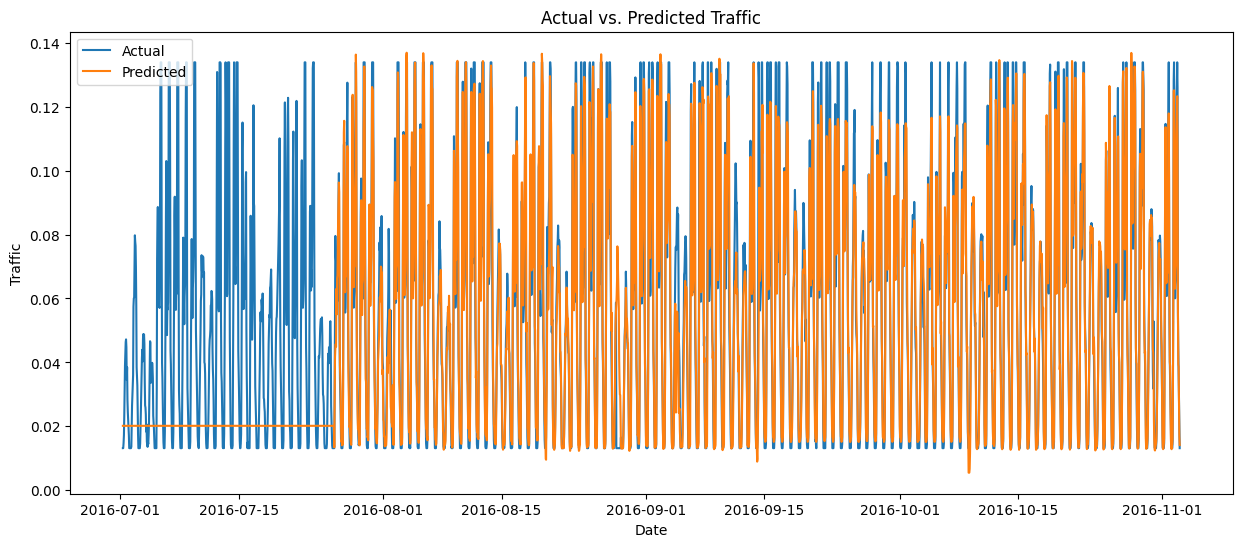

In [27]:
# Create figure
plt.figure(figsize=(15, 6))

# Plot for the actual and predicted values
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Actual'], label='Actual')
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Predicted'], label='Predicted')

# Plot labels and title
plt.xlabel('Date')
plt.ylabel('Traffic')
plt.title('Actual vs. Predicted Traffic')

# Show legend
plt.legend()

# Show plot
plt.show()

In [28]:
# Retrain on all the data
df = create_features(df)

FEATURES = ['day_of_week', 'month', 'day_of_year', 'rolling_min', 'rolling_max',
            'rolling_sum', 'rolling_mean', 'rolling_median', 'rolling_std', 'rolling_quantile_25',
            'rolling_quantile_75', 'lag_7_days', 'lag_14_days', 'lag_21_days', 'lag_28_days', 
            'lag_30_days', 'lag_35_days', 'lag_42_days', 'lag_49_days', 'lag_56_days', 'lag_60_days']

TARGET = 'Traffic'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = lgb.LGBMRegressor(boosting_type='gbdt', 
                        n_estimators=900, 
                        early_stopping_rounds=50,
                        objective='regression', 
                        max_depth=3, 
                        min_child_weight=3, 
                        learning_rate=0.01, 
                        colsample_bytree=0.9, 
                        subsample=0.7,
                        reg_lambda=0)

reg.fit(X_all, y_all, eval_set=[(X_all, y_all)])

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4724
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 21
[LightGBM] [Info] Start training from score 0.056678


C:\Users\ginap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:340: UserWarning: Only training set found, disabling early stopping.
  _log_warning('Only training set found, disabling early stopping.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor(colsample_bytree=0.9, early_stopping_rounds=50,
              learning_rate=0.01, max_depth=3, min_child_weight=3,
              n_estimators=900, objective='regression', reg_lambda=0,
              subsample=0.7)

In [29]:
df.index.max()

Timestamp('2016-11-03 01:00:00')

In [30]:
# Create future DataFrame with hourly frequency
future = pd.date_range(start='2016-11-02 02:00:00', end='2017-03-01 23:00:00', freq='h')
future_df = pd.DataFrame(index=future)

future_df['isFuture'] = True
df['isFuture'] = False

df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

df_and_future


,sensor,date,day_of_week,Traffic,month,day_of_year,rolling_min,rolling_max,rolling_sum,rolling_mean,...,lag_14_days,lag_21_days,lag_28_days,lag_30_days,lag_35_days,lag_42_days,lag_49_days,lag_56_days,lag_60_days,isFuture
2016-07-01 02:00:00,0.022144,2016-07-01 02:00:00,4.0,0.022144,7.0,183.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-07-01 03:00:00,0.026111,2016-07-01 03:00:00,4.0,0.026111,7.0,183.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-07-01 04:00:00,0.019267,2016-07-01 04:00:00,4.0,0.019267,7.0,183.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-07-01 05:00:00,0.013067,2016-07-01 05:00:00,4.0,0.013187,7.0,183.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-07-01 06:00:00,0.010756,2016-07-01 06:00:00,4.0,0.013187,7.0,183.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-01 19:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2017-03-01 20:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2017-03-01 21:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2017-03-01 22:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [31]:
future_with_features = df_and_future.query('isFuture').copy()
future_with_features

,sensor,date,day_of_week,Traffic,month,day_of_year,rolling_min,rolling_max,rolling_sum,rolling_mean,...,lag_14_days,lag_21_days,lag_28_days,lag_30_days,lag_35_days,lag_42_days,lag_49_days,lag_56_days,lag_60_days,isFuture
2016-11-02 02:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.013187,0.013187,0.013187,0.013187,0.013187,0.015922,0.013187,0.013187,0.013187,True
2016-11-02 03:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.013187,0.013187,0.013187,0.013187,0.013187,0.013187,0.013187,0.013187,0.013187,True
2016-11-02 04:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.013187,0.013187,0.013187,0.013187,0.013187,0.013187,0.013187,0.013187,0.013187,True
2016-11-02 05:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.015222,0.015789,0.015744,0.013187,0.015011,0.018544,0.015611,0.015233,0.013187,True
2016-11-02 06:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.037178,0.036956,0.035611,0.013187,0.036056,0.038167,0.036678,0.035600,0.015411,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-01 19:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2017-03-01 20:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2017-03-01 21:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2017-03-01 22:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [32]:
#feature_importance = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
#feature_importance

feature_importance = pd.DataFrame(data=reg.feature_importances_, index=X_train.columns, columns=['importance'])
print(feature_importance)

                     importance
day_of_week                  64
month                        13
day_of_year                 560
rolling_min                 425
rolling_max                 686
rolling_sum                 115
rolling_mean                 17
rolling_median              283
rolling_std                 480
rolling_quantile_25         250
rolling_quantile_75         189
lag_7_days                  921
lag_14_days                 468
lag_21_days                 329
lag_28_days                 200
lag_30_days                 115
lag_35_days                 179
lag_42_days                 101
lag_49_days                 155
lag_56_days                 221
lag_60_days                 118


<Axes: title={'center': 'Feature Importance'}>

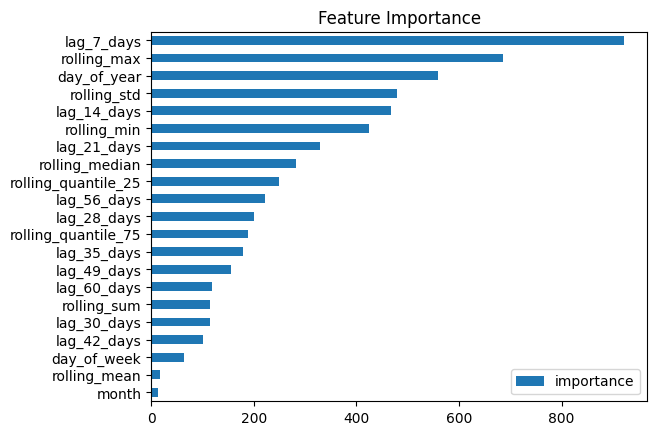

In [33]:
feature_importance \
    .sort_values('importance') \
    .plot(kind='barh', title='Feature Importance')

In [34]:
future_with_features['pred'] = reg.predict(future_with_features[FEATURES])
future_with_features

,sensor,date,day_of_week,Traffic,month,day_of_year,rolling_min,rolling_max,rolling_sum,rolling_mean,...,lag_21_days,lag_28_days,lag_30_days,lag_35_days,lag_42_days,lag_49_days,lag_56_days,lag_60_days,isFuture,pred
2016-11-02 02:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.013187,0.013187,0.013187,0.013187,0.015922,0.013187,0.013187,0.013187,True,0.013096
2016-11-02 03:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.013187,0.013187,0.013187,0.013187,0.013187,0.013187,0.013187,0.013187,True,0.013096
2016-11-02 04:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.013187,0.013187,0.013187,0.013187,0.013187,0.013187,0.013187,0.013187,True,0.013096
2016-11-02 05:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.015789,0.015744,0.013187,0.015011,0.018544,0.015611,0.015233,0.013187,True,0.014042
2016-11-02 06:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.036956,0.035611,0.013187,0.036056,0.038167,0.036678,0.035600,0.015411,True,0.030413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-01 19:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.017514
2017-03-01 20:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.017514
2017-03-01 21:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.017514
2017-03-01 22:00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.017514


In [35]:
# Create a new figure
fig = go.Figure()

fig.add_trace(go.Scatter(x=future_with_features.index, y=future_with_features['pred'],
                         name='Predicted Traffic Arrivals',
                         line=dict(color='blue', width=2),
                         hovertemplate='<b>Date</b>: %{x|%m-%d-%Y}<br>' +
                                       '<b>Traffic</b>: %{y}<br>' +
                                       '<b>Day of Week</b>: %{x| %A}<extra></extra>'))

fig.update_layout(
    title='Future Forecasts of Traffic Arrivals',
    xaxis=dict(
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis_title='Predicted Traffic Arrivals',
    template='plotly_white'
)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')

fig.show()